# Librerie

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import least_squares
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras 
from numpy import loadtxt 
import timeit
import matplotlib.pyplot as plt
import scipy.optimize as spo
from datetime import datetime
import scipy.optimize as opt

2025-03-21 14:59:19.357745: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Modello di Black and Scholes
$$ dS(t) = S(t)\big[rdt + \sigma dW_t\big]$$
dove 
- $\sigma$ è la volatilità dell'asset $S$ (**deve essere calibrata**)
- $S$ è l'asset
- $W_t$ è il  moto Browniano

Il modello di Black and Scholes presenta una formula chiusa per il pricing di opzioni call.
$$C=S_0N(d1) - K e^{-rT}N(d2)$$

In [69]:
def bls(S, K, Vol, r, TTM):
    d1 = (np.log(S/K) + (r + 0.5*Vol**2)*TTM)/(np.sqrt(TTM)*Vol) 
    d2 = d1 - Vol*np.sqrt(TTM)
    C = S*norm.cdf(d1) - K*norm.cdf(d2)*np.exp(-r*TTM) 
    return C

# Modello di Bates
$$
dS_t = S_t \left( \mu dt + \sqrt{v_t} dW_t^S + (e^J - 1) dN_t \right)
$$
$$
dv_t = \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW_t^v
$$

I parametri deterministici sono:
- $S_0$ sottostante
- $K$ strike
- $T$ maturity
- $r$ risk-free rate

I parametri da calibrare sono:
- $\kappa$ (Heston)
- $\theta$ (Heston)
- $v_0$ (Heston)
- $\sigma$ (Heston)
- $\rho$ (Heston)
- $\lambda_J$ (average number of annual jumps)
- $\mu_J$ (jump mean)
- $\sigma_J$ (jump standard deviation)

In [70]:
def simulate_bates(S0, V0, r, kappa, theta, sigma, rho, lambda_J, mu_J, sigma_J, T, N):
    dt = T / N  # Passo temporale
    S = np.zeros(N+1)
    V = np.zeros(N+1)
    S[0] = S0
    V[0] = V0
    
    for t in range(1, N+1):
        Z1 = np.random.normal(0, 1) # moto browniano
        Z2 = np.random.normal(0, 1) # moto browniano
        W_V = Z1
        W_S = rho * Z1 + np.sqrt(1 - rho**2) * Z2  # Correlazione tra i moti browniani

        # Processo di volatilità (Heston)
        V[t] = np.abs(V[t-1] + kappa * (theta - V[t-1]) * dt + sigma * np.sqrt(V[t-1]) * np.sqrt(dt) * W_V)

        # Salti di Poisson
        N_J = np.random.poisson(lambda_J * dt)
        J = np.sum(np.random.normal(mu_J, sigma_J, N_J)) if N_J > 0 else 0
        
        # Processo del sottostante con volatilità stocastica e salti
        S[t] = S[t-1] * np.exp((r - 0.5 * V[t-1]) * dt + np.sqrt(V[t-1]) * np.sqrt(dt) * W_S + J)
    
    return S

Generiamo un processo di Bates inizializzando i parametri

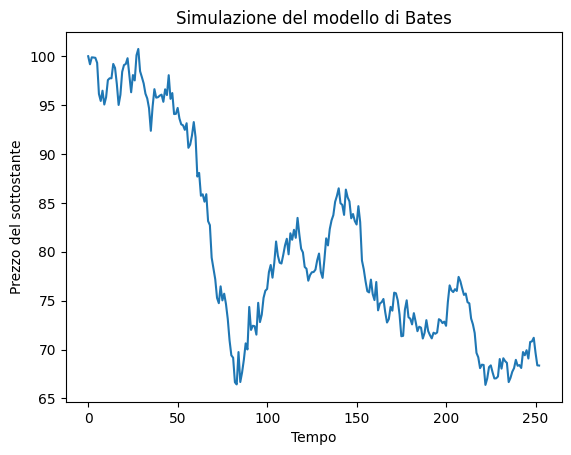

In [71]:
S0 = 100      # Prezzo iniziale
V0 = 0.04     # Volatilità iniziale
r = 0.05      # Tasso risk-free
kappa = 2.0   # Velocità di ritorno alla media
theta = 0.04  # Media della varianza
sigma = 0.2   # Volatilità della volatilità
rho = -0.5    # Correlazione tra asset e volatilità
lambda_J = 0.1 # Intensità dei salti
mu_J = -0.02  # Media dei salti
sigma_J = 0.1 # Deviazione standard dei salti
T = 1         # Scadenza di 1 anno
N = 252       # Passaggi temporali

# Simulazione
S_sim = simulate_bates(S0, V0, r, kappa, theta, sigma, rho, lambda_J, mu_J, sigma_J, T, N)

# Grafico
plt.plot(S_sim)
plt.xlabel("Tempo")
plt.ylabel("Prezzo del sottostante")
plt.title("Simulazione del modello di Bates")
plt.show()

Il modello di Bates non presenta forme chiuse per il calcolo del prezzo di opzioni, di conseguenza possiamo usare il metodo Monte Carlo per simulare più processi.

In [72]:
def bates_call_price(S0, V0, r, kappa, theta, sigma, rho, lambda_J, mu_J, sigma_J, T, K, N, M):
    payoffs = []
    
    # generiamo M processi di bates
    for _ in range(M):
        S_sim = simulate_bates(S0, V0, r, kappa, theta, sigma, rho, lambda_J, mu_J, sigma_J, T, N)
        ST = S_sim[-1]  # prezzo alla scadenza
        payoff = max(ST - K, 0)  # payoff della call
        payoffs.append(payoff)
    
    # scontiamo la media dei payoffs
    return np.exp(-r * T) * np.mean(payoffs)

Testiamo i due modelli (scalibrati) per la generazione del prezzo di una call con:
- strike K = 70
- TTM = 1

In [73]:
S0 = 100      # Prezzo iniziale
V0 = 0.04     # Volatilità iniziale
r = 0.05      # Tasso risk-free
kappa = 2.0   # Velocità di ritorno alla media
theta = 0.04  # Media della varianza
sigma = 0.2   # Volatilità della volatilità
rho = -0.5    # Correlazione tra asset e volatilità
lambda_J = 0.1 # Intensità dei salti
mu_J = -0.02  # Media dei salti
sigma_J = 0.1 # Deviazione standard dei salti
T = 1         # Scadenza di 1 anno
N = 252       # Passaggi temporali
K = 70        # Strike
M = 10000     # simulazioni MC

In [74]:
bates_call_price(S0, V0, r, kappa, theta, sigma, rho, lambda_J, mu_J, sigma_J, T, K, N, M)

33.53400603442977

In [75]:
bls(S0, K, sigma, r, T)

33.54009835541592

# Calibrazione classica
Per prima cosa, siccome non trovo dataset online, genero un dataset sintetico

In [76]:
# Creazione di un dataset fittizio
data = {
    'Strike': np.arange(190, 290, 2),  # Strike price da 190 a 290 con step di 2
    'Bid': np.linspace(20, 5, 50),  # Prezzo Bid decrescente
    'Ask': np.linspace(22, 7, 50)   # Prezzo Ask decrescente
}

# Creazione del DataFrame
data = pd.DataFrame(data)

# Calcolare il prezzo medio (Mid price)
data['Mid'] = (data['Ask'] + data['Bid']) / 2

# Parametri del modello
S = 241.20  # Prezzo del sottostante
r = 0.0145  # risk free rate 
TTM = 1.5   # time to maturity  

data.head()

,Strike,Bid,Ask,Mid
0,190,20.000000,22.000000,21.000000
1,192,19.693878,21.693878,20.693878
2,194,19.387755,21.387755,20.387755
3,196,19.081633,21.081633,20.081633
4,198,18.775510,20.775510,19.775510


## Black - Scholes

Definiamo la funzione obiettivo come la differenza tra il prezzo di mercato e il prezzo generato dal modello

In [77]:
def diff_bls(Vol):
    return sum((data['Mid'] - bls(S, data['Strike'], Vol, r, TTM))**2) 

Minimizziamo la funzione cercando così il parametro calibrato

In [78]:
best_vol = opt.minimize(diff_bls, x0=0.3, bounds=[(0.01, 1)], method="L-BFGS-B")
best_vol.x[0]

0.08158575716617143

Confrontiamo gli errori

In [79]:
mape_no_cal = 100*mean_absolute_percentage_error(data['Mid'], 
                                                 bls(S, data['Strike'], 0.2, r, TTM))

mape_cal = 100*mean_absolute_percentage_error(data['Mid'], 
                                                 bls(S, data['Strike'], best_vol.x[0], r, TTM))

print('mape senza calibrazione', mape_no_cal)
print('mape con calibrazione', mape_cal)

mape senza calibrazione 108.26805695759276
mape con calibrazione 71.27162167229238


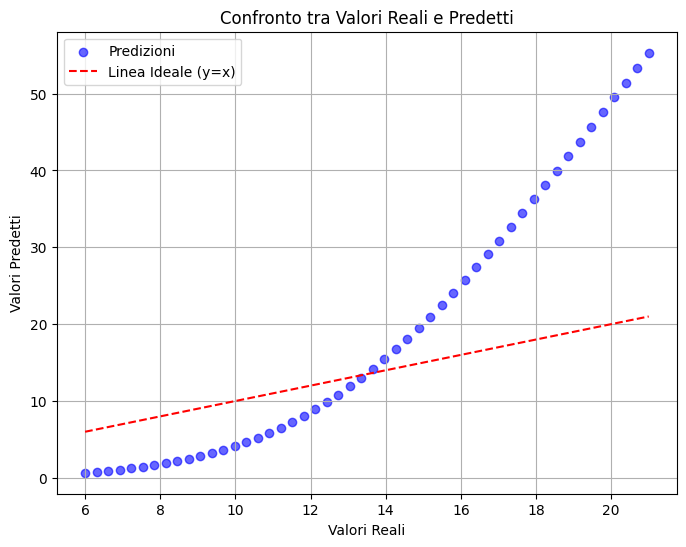

In [80]:
# Creazione del grafico
plt.figure(figsize=(8, 6))
plt.scatter(data['Mid'], bls(S, data['Strike'], best_vol.x[0], r, TTM), 
            alpha=0.6, label="Predizioni", color="blue")
plt.plot([min(data['Mid']), max(data['Mid'])], 
         [min(data['Mid']), max(data['Mid'])], '--r', label="Linea Ideale (y=x)")

# Etichette e titolo
plt.xlabel("Valori Reali")
plt.ylabel("Valori Predetti")
plt.title("Confronto tra Valori Reali e Predetti")
plt.legend()
plt.grid(True)

# Mostra il grafico
plt.show()

## Bates

Definiamo la funzione obiettivo

In [40]:
def loss_function(params):
    V0, kappa, theta, sigma, rho, lambda_J, mu_J, sigma_J = params
    errors = []
    
    for _, row in data.iterrows():
        K, C_mkt, T = row["Strike"], row["Mid"], 1.5
        C_model = bates_call_price(S0, V0, r, kappa, theta, sigma, rho, lambda_J, mu_J, sigma_J, T, K, N, M)
        errors.append((C_model - C_mkt) ** 2)
    
    return np.sum(errors)

Cerchiamo i parametri, ma la ricerca ci mette veramente troppo tempo, dovuto anche alla simulazione Monte Carlo. 

Con un dataset di 5 righe ci impiega circa 11 ore e l'errore è piuttosto elevato.

In [41]:
# Parametri iniziali e limiti
initial_guess = [0.04, 2.0, 0.04, 0.2, -0.5, 0.1, -0.02, 0.1]
bounds = [(0.001, 0.5), (0.1, 5), (0.001, 0.5), (0.01, 1), (-1, 1), (0.01, 1), (-0.1, 0.1), (0.01, 0.5)]

# Ottimizzazione
result = opt.minimize(loss_function, initial_guess, bounds=bounds, method="L-BFGS-B")

# Output dei parametri calibrati
calibrated_params = result.x
param_names = ["V0", "kappa", "theta", "sigma", "rho", "lambda_J", "mu_J", "sigma_J"]
calibrated_dict = {name: value for name, value in zip(param_names, calibrated_params)}

print("Parametri calibrati:", calibrated_dict)

KeyboardInterrupt: 

# Calibrazione con Neural Network
Lo scopo è il seguente:
$$ \bm{w}^* = \arg\min_{\bm{w}} \sum_{i \in [n]} w_i \ell \left( y_i, f \left( x_i; g(x_i, y_i; \bm{w}) \right) \right)  $$

dove:
- $f$ è il modello di pricing che genera il prezzo della call. Tale funzione riceve in input:
    - $x_i$ ovvero i parametri da NON calibrare (sottostante, tasso risk-free, TTM)
    - $g$ è la rete neurale che genera i parametri calibrati. Tale rete viene allenata su istanze del tipo $(x_i, y_i)$ ==> $\theta_i$. 
    Dove $y_i$ è il prezzo della call

## Black and Scholes

Siccome non dispongo di un dataset che mi unisca $(x_i, y_i, \theta_i)$, prendo il parametro calibrato precedentemente con il metodo classico e lo perturbo con una distribuzione normale in modo tale da avere diversi samples della volatilità.

In [97]:
Volat = np.abs(np.random.normal(best_vol.x[0], 0.1 * best_vol.x[0], 10000)) # perturbazione
print(Volat)
print(Volat.shape)

[0.07630752 0.09200851 0.08633917 ... 0.07766126 0.07366735 0.08405976]
(10000,)


Creo la prima riga del dataset

In [82]:
dataset_ML = np.array([np.append(data['Mid'].values, best_vol.x[0])])
dataset_ML

array([[21.        , 20.69387755, 20.3877551 , 20.08163265, 19.7755102 ,
        19.46938776, 19.16326531, 18.85714286, 18.55102041, 18.24489796,
        17.93877551, 17.63265306, 17.32653061, 17.02040816, 16.71428571,
        16.40816327, 16.10204082, 15.79591837, 15.48979592, 15.18367347,
        14.87755102, 14.57142857, 14.26530612, 13.95918367, 13.65306122,
        13.34693878, 13.04081633, 12.73469388, 12.42857143, 12.12244898,
        11.81632653, 11.51020408, 11.20408163, 10.89795918, 10.59183673,
        10.28571429,  9.97959184,  9.67346939,  9.36734694,  9.06122449,
         8.75510204,  8.44897959,  8.14285714,  7.83673469,  7.53061224,
         7.2244898 ,  6.91836735,  6.6122449 ,  6.30612245,  6.        ,
         0.08158576]])

Ora per ogni volatilità perturbata e ogni strikes, calcolo il prezzo Black and Scholes e 'popolo' il dataset

In [83]:
# Simulazione dei prezzi teorici delle call per ogni volatilità perturbata
for vol in Volat:
    Call_sim = bls(S, data['Strike'], vol, r, TTM) 
    Call_sim = np.append(Call_sim, vol)  # Aggiunge la volatilità usata
    dataset_ML = np.vstack((dataset_ML, Call_sim))  # Stacka la nuova riga

df = pd.DataFrame(dataset_ML)
df.columns = list(data['Strike']) + ['Volatility']
df

,190,192,194,196,198,200,202,204,206,208,...,272,274,276,278,280,282,284,286,288,Volatility
0,21.000000,20.693878,20.387755,20.081633,19.775510,19.469388,19.163265,18.857143,18.551020,18.244898,...,8.448980,8.142857,7.836735,7.530612,7.224490,6.918367,6.612245,6.306122,6.000000,0.081586
1,55.304905,53.355555,51.409107,49.466461,47.528723,45.597230,43.673574,41.759623,39.857534,37.969759,...,1.820080,1.567646,1.345740,1.151442,0.981981,0.834754,0.707329,0.597457,0.503072,0.076872
2,55.303280,53.353339,51.406134,49.462532,47.523605,45.590657,43.665249,41.749220,39.844703,37.954133,...,1.766866,1.518599,1.300780,1.110447,0.944796,0.801196,0.677195,0.570529,0.479123,0.076125
3,55.313863,53.367566,51.424979,49.487139,47.555291,45.630911,43.715718,41.811691,39.921072,38.046367,...,2.066608,1.795871,1.555931,1.344048,1.157604,0.994119,0.851260,0.726851,0.618873,0.080237
4,55.342107,53.404136,51.471729,49.546163,47.628918,45.721678,43.826344,41.945027,40.080046,38.233918,...,2.600475,2.294836,2.020157,1.774036,1.554150,1.358274,1.184285,1.030173,0.894048,0.087090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,55.306456,53.357656,51.411912,49.470151,47.533506,45.603344,43.681286,41.769222,39.869330,37.984074,...,1.867868,1.611760,1.386246,1.188440,1.015603,0.865154,0.734683,0.621952,0.524905,0.077537
9997,55.338341,53.399339,51.465691,49.538653,47.619682,45.710446,43.812830,41.928935,40.061081,38.211786,...,2.541316,2.239268,1.968184,1.725627,1.509244,1.316782,1.146096,0.995158,0.862061,0.086355
9998,55.376561,53.447303,51.525208,49.611705,47.708397,45.817075,43.939707,42.078437,40.235572,38.413565,...,3.053748,2.722500,2.422065,2.150280,1.905041,1.684311,1.486135,1.308645,1.150067,0.092564
9999,55.332305,53.391607,51.455909,49.526425,47.604573,45.691988,43.790527,41.902275,40.029542,38.174851,...,2.440602,2.144817,1.879989,1.643624,1.433314,1.246761,1.081779,0.936310,0.808422,0.085091


Ogni riga presenta i prezzi delle call per diversi strike (in colonna) e l'ultima colonna si riferisce al parametro della volatilità calibrato

Andiamo ora a splittare i dati in train e test e a standardizzarli. 

La rete andrà a comprendere come associare i vari prezzi (riferiti ai vari strike) con i parametri riferiti alla calibrazione.

In [84]:
X = df[df.columns[0:50]] # solo i prezzi
y = df['Volatility']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.90, random_state = 90)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Stampa delle dimensioni dei dataset
print("Dimensione X_train:", X_train_scaled.shape)
print("Dimensione y_train:", y_train.shape)
print("Dimensione X_test:", X_test_scaled.shape)
print("Dimensione y_test:", y_test.shape)

Dimensione X_train: (9000, 50)
Dimensione y_train: (9000,)
Dimensione X_test: (1001, 50)
Dimensione y_test: (1001,)


Training della rete

Epoch 1/150
265/265 [==============================] - 2s 4ms/step - loss: 0.0160 - mae: 0.0160 - val_loss: 0.0094 - val_mae: 0.0094
Epoch 2/150
265/265 [==============================] - 1s 3ms/step - loss: 0.0094 - mae: 0.0094 - val_loss: 0.0094 - val_mae: 0.0094
Epoch 3/150
265/265 [==============================] - 1s 3ms/step - loss: 0.0112 - mae: 0.0112 - val_loss: 0.0042 - val_mae: 0.0042
Epoch 4/150
265/265 [==============================] - 1s 3ms/step - loss: 0.0063 - mae: 0.0063 - val_loss: 0.0042 - val_mae: 0.0042
Epoch 5/150
265/265 [==============================] - 1s 3ms/step - loss: 0.0080 - mae: 0.0080 - val_loss: 0.0024 - val_mae: 0.0024
Epoch 6/150
265/265 [==============================] - 1s 3ms/step - loss: 0.0042 - mae: 0.0042 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 7/150
265/265 [==============================] - 1s 2ms/step - loss: 0.0048 - mae: 0.0048 - val_loss: 0.0016 - val_mae: 0.0016
Epoch 8/150
265/265 [==============================] - 1s 3ms/step - 

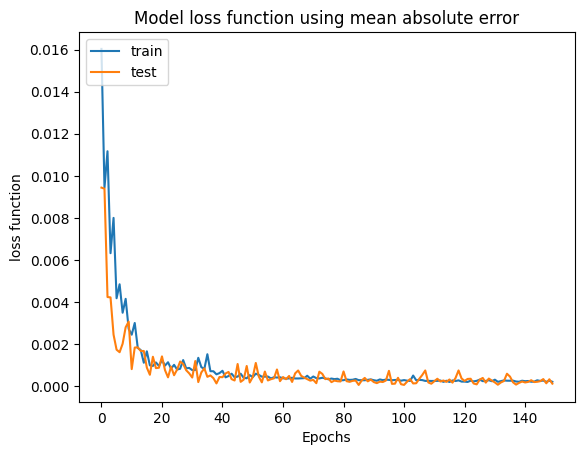

In [85]:
model_mae = keras.models.Sequential()
model_mae.add(keras.layers.Dense(41, input_dim=X_train.shape[1], activation='relu'))
model_mae.add(keras.layers.Dense(64, activation='relu'))
model_mae.add(keras.layers.Dense(1, activation='linear'))

model_mae.compile(optimizer='adam', loss='mae', metrics=['mae'])

history_mae = model_mae.fit(X_train_scaled, y_train, epochs= 150, batch_size = 34, 
                            validation_data=(X_test_scaled, y_test), verbose = 1)

fig = plt.figure()
plt.plot(history_mae.history['loss'])
plt.plot(history_mae.history['val_loss'])
plt.title ('Model loss function using mean absolute error') 
plt.ylabel('loss function')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')

Facciamo la previsione sul test set

In [86]:
y_pred = model_mae.predict(X_test_scaled)

#calcoliamo l'errore
mae = mean_absolute_error(y_test, y_pred)
mape = 100*mean_absolute_percentage_error(y_test, y_pred)

print('mae', mae)
print('mape', mape)

32/32 [==============================] - 0s 6ms/step
mae 0.00011935402256908874
mape 0.15509986773783513


Salviamo in un dataset i prezzi generati con i parametri calibrati dalla rete neurale

In [88]:
predicted_prices_nn = []
predicted_prices_nn = np.array([bls(S, data['Strike'], y_pred[0], 0.0145, 1.5)])
predicted_prices_nn

array([[55.49823874, 53.59403292, 51.7005395 , 49.8193548 , 47.95220227,
        46.10092502, 44.26747548, 42.45390238, 40.66233506, 38.89496552,
        37.1540283 , 35.44177871, 33.76046982, 32.11232856, 30.49953153,
        28.924181  , 27.38828153, 25.89371771, 24.4422335 , 23.03541349,
        21.67466647, 20.36121156, 19.09606704, 17.88004216, 16.71373185,
        15.59751437, 14.53155188, 13.51579367, 12.54998209, 11.63366065,
        10.76618435,  9.94673174,  9.17431844,  8.44781195,  7.76594724,
         7.12734298,  6.53051807,  5.97390811,  5.45588179,  4.97475669,
         4.52881456,  4.11631576,  3.73551274,  3.38466259,  3.06203838,
         2.76593943,  2.49470034,  2.24669891,  2.02036285,  1.81417539]])

In [89]:
for i in range(1 , len(y_pred)):
    predicted_prices_nn = np.vstack((predicted_prices_nn, [bls(S, data['Strike'],
                                                              y_pred[i], 0.0145, 1.5)]))

predicted_prices_nn

array([[55.49823874, 53.59403292, 51.7005395 , ...,  2.24669891,
         2.02036285,  1.81417539],
       [55.2910801 , 53.33605495, 51.38205424, ...,  0.34900945,
         0.28222716,  0.22720904],
       [55.31998718, 53.37563361, 51.43546081, ...,  0.9350804 ,
         0.80272757,  0.68726788],
       ...,
       [55.30020226, 53.34910611, 51.40040296, ...,  0.61511873,
         0.51525898,  0.43015387],
       [55.29914416, 53.34763652, 51.39839519, ...,  0.59188275,
         0.49464485,  0.41195811],
       [55.30302009, 53.35298467, 51.40565682, ...,  0.67223243,
         0.56610094,  0.47519058]])

Calcoliamo l'errore tra i prezzi generati con la calibrazione rete neurale e quelli originali

In [93]:
error_matrix = 100*(abs(X_test - predicted_prices_nn)/X_test)
error_matrix

,190,192,194,196,198,200,202,204,206,208,...,270,272,274,276,278,280,282,284,286,288
6125,0.002155,0.002641,0.003213,0.003881,0.004656,0.005550,0.006576,0.007744,0.009067,0.010559,...,0.193802,0.205095,0.216737,0.228725,0.241058,0.253731,0.266744,0.280092,0.293772,0.307781
4195,0.000344,0.000535,0.000818,0.001227,0.001807,0.002618,0.003729,0.005228,0.007220,0.009825,...,1.440750,1.556592,1.677294,1.802808,1.933079,2.068047,2.207647,2.351808,2.500459,2.653521
3673,0.000549,0.000745,0.000998,0.001322,0.001732,0.002244,0.002877,0.003652,0.004591,0.005718,...,0.271448,0.290399,0.310055,0.330410,0.351459,0.373196,0.395614,0.418707,0.442468,0.466888
5643,0.000382,0.000521,0.000703,0.000937,0.001234,0.001606,0.002069,0.002639,0.003332,0.004167,...,0.208978,0.223699,0.238971,0.254792,0.271158,0.288064,0.305505,0.323475,0.341970,0.360982
8017,0.000331,0.000518,0.000796,0.001199,0.001775,0.002583,0.003695,0.005202,0.007211,0.009848,...,1.508175,1.629961,1.756873,1.888858,2.025856,2.167804,2.314631,2.466262,2.622619,2.783620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4198,0.000526,0.000684,0.000881,0.001123,0.001419,0.001776,0.002204,0.002713,0.003312,0.004013,...,0.130613,0.139171,0.148027,0.157180,0.166627,0.176366,0.186394,0.196709,0.207306,0.218185
7349,0.000375,0.000488,0.000629,0.000803,0.001015,0.001272,0.001580,0.001945,0.002377,0.002882,...,0.094655,0.100868,0.107299,0.113945,0.120806,0.127878,0.135162,0.142654,0.150352,0.158255
709,0.000541,0.000776,0.001097,0.001528,0.002100,0.002846,0.003809,0.005035,0.006576,0.008492,...,0.647480,0.695810,0.746050,0.798185,0.852199,0.908073,0.965787,1.025321,1.086650,1.149752
4136,0.000504,0.000726,0.001032,0.001445,0.001994,0.002715,0.003649,0.004842,0.006348,0.008226,...,0.655725,0.704957,0.756145,0.809275,0.864330,0.921289,0.980134,1.040842,1.103389,1.167751


Errore medio per strike

In [94]:
mean_error_per_strike_nn = error_matrix.mean()
mean_error_per_strike_nn

190    0.000647
192    0.000873
194    0.001167
196    0.001546
198    0.002029
200    0.002641
202    0.003408
204    0.004360
206    0.005532
208    0.006963
210    0.008694
212    0.010771
214    0.013242
216    0.016159
218    0.019576
220    0.023549
222    0.028134
224    0.033390
226    0.039373
228    0.046141
230    0.053749
232    0.062252
234    0.071700
236    0.082142
238    0.093625
240    0.106190
242    0.119877
244    0.134721
246    0.150753
248    0.168001
250    0.186490
252    0.206238
254    0.227264
256    0.249580
258    0.273196
260    0.298121
262    0.324357
264    0.351907
266    0.380769
268    0.410941
270    0.442417
272    0.475189
274    0.509250
276    0.544587
278    0.581190
280    0.619045
282    0.658138
284    0.698454
286    0.739976
288    0.782687
dtype: float64

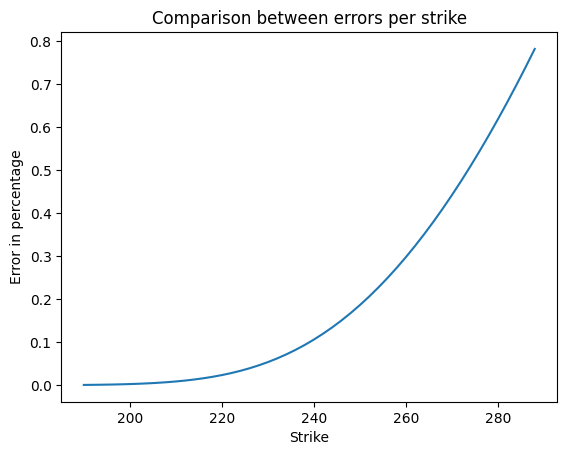

In [96]:
plt.title ('Comparison between errors per strike') 
plt.ylabel('Error in percentage') 
plt.xlabel('Strike')
plt.plot(data['Strike'], mean_error_per_strike_nn)
plt.show()